In [1]:
!pip install sparselinear

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[Paper parameters](https://github.com/marakeby/pnet_prostate_paper/blob/master/train/params/P1000/pnet/onsplit_average_reg_10_tanh_large_testing.py)

[Pipeline](https://github.com/marakeby/pnet_prostate_paper/blob/master/pipeline/train_validate.py)

In [1]:
import torch
import torch.utils.data as data
import os
import itertools
import json
import pandas as pd
import random
import numpy as np
import scipy

In [2]:
# Save model

def save_model (model, name):
  torch.save(model.state_dict(), "/content/drive/MyDrive/Colab Notebooks/ECBM E4060/Project/" + name)

In [5]:
# Grab original paper for the data
!git clone https://github.com/marakeby/pnet_prostate_paper.git

Cloning into 'pnet_prostate_paper'...
remote: Enumerating objects: 758, done.
remote: Counting objects: 100% (189/189), done.
remote: Compressing objects: 100% (86/86), done.
remote: Total 758 (delta 124), reused 103 (delta 103), pack-reused 569
Receiving objects: 100% (758/758), 5.34 MiB | 16.00 MiB/s, done.
Resolving deltas: 100% (444/444), done.


Get data and preprocess (Need to have _database folder from paper)

In [6]:
!unzip '/content/drive/MyDrive/Colab Notebooks/ECBM E4060/Project/_database.zip' -d '/content/_database'

Archive:  /content/drive/MyDrive/Colab Notebooks/ECBM E4060/Project/_database.zip
   creating: /content/_database/_database/
   creating: /content/_database/_database/prostate/
  inflating: /content/_database/_database/prostate/.DS_Store  
   creating: /content/_database/__MACOSX/
   creating: /content/_database/__MACOSX/_database/
   creating: /content/_database/__MACOSX/_database/prostate/
  inflating: /content/_database/__MACOSX/_database/prostate/._.DS_Store  
   creating: /content/_database/_database/prostate/raw_data/
  inflating: /content/_database/_database/prostate/raw_data/.DS_Store  
   creating: /content/_database/__MACOSX/_database/prostate/raw_data/
  inflating: /content/_database/__MACOSX/_database/prostate/raw_data/._.DS_Store  
  inflating: /content/_database/_database/prostate/raw_data/outputs_p1000_rna_n=660_tpm_matrix.tsv  
  inflating: /content/_database/__MACOSX/_database/prostate/raw_data/._outputs_p1000_rna_n=660_tpm_matrix.tsv  
  inflating: /content/_database/

In [2]:
import pandas as pd

P1000_data = pd.read_csv("/content/_database/_database/prostate/processed/P1000_data_CNA_paper.csv", index_col=0)
test_set = pd.read_csv("/content/_database/_database/prostate/splits/test_set.csv", index_col=0).set_index("id")
training_set = pd.read_csv("/content/_database/_database/prostate/splits/training_set.csv", index_col=0).set_index("id")
validation_set = pd.read_csv("/content/_database/_database/prostate/splits/validation_set.csv", index_col=0).set_index("id")
counts = pd.read_csv("/content/_database/_database/prostate/processed/p1000_read_counts.csv", index_col=0)
tpm = pd.read_csv("/content/_database/_database/prostate/processed/P1000_adjusted_TPM.csv", index_col=0)
star_fus = pd.read_csv("/content/_database/_database/prostate/processed/fusion_genes.csv", index_col=0)
sample_mapping = pd.read_csv("/content/_database/_database/prostate/raw_data/sample_mapping.tsv", index_col=0, sep='\t')
tcga = pd.read_csv("/content/_database/_database/genes/tcga_prostate_expressed_genes_and_cancer_genes.csv", index_col=0)

In [4]:
training_set.head()

,response
id,
TCGA-KK-A8I5,0
TCGA-2A-A8W3,0
SC_9090,1
PR-02-1082,0
TCGA-EJ-5494,0


In [9]:
sample_mapping.head()

,patient,rna_sample_id,tpm_col,fusion_name
Tumor_Sample_Barcode,,,,
TCGA-EJ-5499,PRAD-TCGA-EJ-5499-Tumor-SM-1U3IG,PRAD-EJ-5499-TP,PRAD-EJ-5499-TP_polyA,PRAD-EJ-5499-TP
MO_1012,MO_1012-Tumor-Abdomen_wall_nodule,MO_1012-Tumor-Subcutaneous_nodule,MO_1012-Tumor-Subcutaneous_nodule_polyA,MO_1012-Tumor-Subcutaneous_nodule
TCGA-CH-5752,PRAD-TCGA-CH-5752-Tumor-SM-1U3ID,PRAD-CH-5752-TP,PRAD-CH-5752-TP_polyA,PRAD-CH-5752-TP
06-134H1_LN,06-134H1_LN,NaN,NaN,NaN
SC_9126,SC_9126_Tumor,SC_9126_Tumor,SC_9126_Tumor_tcap,SC_9126_Tumor


In [10]:
tpm.head()

,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,...,H2BE1,GET1.SH3BGR,SPDYE15,NOTCH2NLB,SPDYE13,ASDURF,SPEGNB,SPDYE14,DERPC,NOTCH2NLC
TCGA-EJ-5499,67.0,0.05,37.0,9.0,3.0,2.00,7.0,38.0,24.0,13.0,...,0.00,0.38,0.0,38.0,0.0,3.0,0.39,0.0,19.0,3.00
MO_1012,41.0,0.00,29.0,5.0,9.0,1.00,9.0,32.0,16.0,19.0,...,0.00,0.00,0.0,21.0,0.0,16.0,0.00,0.0,0.0,7.00
TCGA-CH-5752,12.0,0.05,36.0,9.0,3.0,1.00,5.0,62.0,17.0,20.0,...,0.09,0.17,0.0,24.0,0.0,5.0,0.78,0.0,19.0,7.00
SC_9126,12.0,0.08,68.0,8.0,30.0,6.00,12.0,47.0,91.0,29.0,...,0.00,4.00,0.0,0.0,0.0,4.0,1.00,0.0,22.0,0.23
PROS01448-6115227-SM-67ERU,25.0,0.08,46.0,10.0,5.0,0.43,2.0,52.0,48.0,28.0,...,0.00,0.20,0.0,9.0,0.0,1.0,0.17,0.0,6.0,3.00


In [11]:
test_set.head()

,response
id,
TCGA-HC-8261,0
TCGA-KK-A8IH,0
AAPC-STID0000021584-Tumor-SM-2XTZ6,0
TCGA-YL-A9WI,0
TCGA-KK-A7AY,0


In [3]:
import sys

sys.path.insert(0,'/content/drive/MyDrive/Colab Notebooks/ECBM E4060/Project')

In [4]:
from Scripts.layers import Attention, AttLayer, DiagLayer, SparseTF
from Scripts.model import ReactomeNetwork

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


Pull pathways from database and construct layers

In [6]:
pathways = pd.read_excel('/content/_database/_database/pathways/pathways_short_names.xlsx')

reactomenetwork = ReactomeNetwork()
layers = reactomenetwork.get_layers(5)

Generate maps from pathways

In [7]:
def get_map(genes, n_levels):
  map = []
  filtering_index = genes

  for i, layer in enumerate(layers[::-1]):
    pathways = list(layer.keys())
    pathway_genes = list(np.unique(list(itertools.chain.from_iterable(layer.values()))))

    n_pathways = len(pathways)
    n_genes = len(pathway_genes)
    
    mat = np.zeros((n_pathways, n_genes))

    for p, g in layer.items():
      g_index = [pathway_genes.index(g_) for g_ in g]
      p_index = pathways.index(p)

      mat[p_index][g_index] = 1

    mapp = pd.DataFrame(mat, index=pathways, columns=pathway_genes).T

    filter_df = pd.DataFrame(index=filtering_index)
    filtered_map = filter_df.merge(mapp, right_index=True, left_index=True, how='left')
    filtered_map = filtered_map.fillna(0)

    filtering_index = filtered_map.columns

    map.append(filtered_map)

  return map

maps = get_map(tcga.index.values, 5)

Create a dataset

In [8]:
import torch.utils.data as data
import torch.nn.functional as F

class CustomDataset(data.Dataset):
  def __init__(self, data_set, tpm, genes):
    self.x = []
    self.y = []

    # Sort and get dataframes aligned
    ids = data_set.index.values
    retpm = tpm.reindex(ids).dropna()
    ids_act = retpm.index.values
    merge = pd.concat([tpm.loc[ids_act], data_set.loc[ids_act]], axis=1, join="inner")

    # Make sure we only use the genes defined in the tcga file
    self.genes = np.intersect1d(genes, tpm.columns.values)
    merge = merge.loc[:, merge.columns.isin(self.genes)]

    # Put the response back in
    merge["response"] = data_set.loc[:,data_set.columns=="response"]

    # Add tpm data to X and cancer presence to y
    x = merge.loc[:, merge.columns!='response']
    y = merge.loc[:, merge.columns=='response']

    self.x = torch.tensor(x.values,dtype=torch.float32)
    self.y = torch.tensor(y.values,dtype=torch.float32)

  def __getitem__(self, index):
    return self.x[index], self.y[index]

  def __len__(self):
    return len(self.x)

  def n_genes(self):
    return len(self.genes)

Initialize Datasets

In [9]:
genes = tcga.index.values

train_data = CustomDataset(training_set, tpm, genes)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=4, shuffle=True)

validation_data = CustomDataset(validation_set, tpm, genes)
validation_loader = torch.utils.data.DataLoader(validation_data, batch_size=4, shuffle=True)

test_data = CustomDataset(test_set, tpm, genes)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=4, shuffle=True)

n_genes = train_data.n_genes()

Define the model

Build using same structure as defined in [this file](https://github.com/marakeby/pnet_prostate_paper/blob/master/model/builders/builders_utils.py)

In [28]:
import torch.nn as nn
import torch.nn.functional as F

class NN(nn.Module):
  def __init__(self, input_shape, map, wregs = [0.001] * 7):
    super(NN, self).__init__()

    self.input_shape = input_shape
    self.maps = map
    self.wregs = wregs

    #self.diag = DiagLayer(self.input_shape, self.input_shape)
    self.fc1 = nn.Linear(self.input_shape, self.maps[0].shape[0])
    self.tan1 = nn.Tanh()

    self.pnetlayers = nn.ModuleList()

    for i, map in enumerate(self.maps[0:-1]):
      wreg = self.wregs[i]

      n_genes, n_pathways = map.shape

      self.pnetlayers.append(SparseTF(n_genes, n_pathways, device=device, mask=map))
      self.pnetlayers.append(nn.Tanh())
      self.pnetlayers.append(nn.Dropout(p=0.5))

      final = n_pathways

    self.final = nn.Linear(final, 1)

  def forward(self, x):
    #x = self.diag(x)

    x = self.fc1(x)
    x = self.tan1(x)

    for i, l in enumerate(self.pnetlayers):
      x = self.pnetlayers[i](x)

    x = self.final(x)

    return x
    
net = NN(n_genes, maps).to(device)  # operate on GPU
print(net)

NN(
  (fc1): Linear(in_features=10346, out_features=14665, bias=True)
  (tan1): Tanh()
  (pnetlayers): ModuleList(
    (0): SparseTF(in_features=14665, out_features=1387, bias=True)
    (1): Tanh()
    (2): Dropout(p=0.5, inplace=False)
    (3): SparseTF(in_features=1387, out_features=1066, bias=True)
    (4): Tanh()
    (5): Dropout(p=0.5, inplace=False)
    (6): SparseTF(in_features=1066, out_features=447, bias=True)
    (7): Tanh()
    (8): Dropout(p=0.5, inplace=False)
    (9): SparseTF(in_features=447, out_features=147, bias=True)
    (10): Tanh()
    (11): Dropout(p=0.5, inplace=False)
    (12): SparseTF(in_features=147, out_features=26, bias=True)
    (13): Tanh()
    (14): Dropout(p=0.5, inplace=False)
  )
  (final): Linear(in_features=26, out_features=1, bias=True)
)


Define loss function and optimizer

In [36]:
import torch.optim as optim

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

Train the model

In [38]:
# Training function

def train_model (model, n_epochs, train_loader, optimizer, criterion):
  model.train()
  for epoch in range(n_epochs):  # loop over the dataset multiple times
    if (epoch % 5 == 0):
      print(epoch)
    for i, data in enumerate(train_loader, 0):
      optimizer.zero_grad()   # zero the gradient buffers
      output = model(data[0].to(device))
      loss = criterion(output, data[1].to(device))
      loss.backward()
      optimizer.step()
      pass

train_model(net, 100, train_loader, optimizer, criterion)

0
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95


Accuracy:  0.6417910447761194


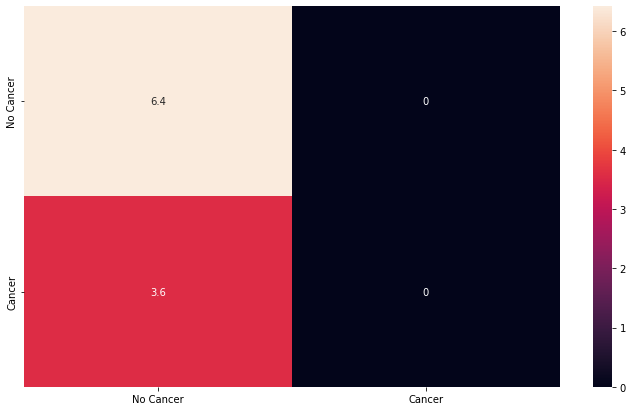

In [39]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

classes_2_list = [0, 1]
classes_2 = ["No Cancer", "Cancer"]

def plot_confusion (model, test_loader):

  y_pred = []
  y_true = []

  model.eval()
  with torch.no_grad():
    for data in test_loader:
      output = model(data[0].to(device))
      output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
      y_pred.extend(output)

      labels = data[1].data.cpu().numpy()
      y_true.extend(labels)
      pass

  st = set(classes_2_list[:len(classes_2_list)//2])

  unmod = accuracy_score(y_true, y_pred)

  print("Accuracy: ", unmod)

  cf_matrix = confusion_matrix(y_true, y_pred)

  df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes_2],
                      columns = [i for i in classes_2])
  plt.figure(figsize = (12,7))
  sn.heatmap(df_cm, annot=True)
  #plt.savefig('output1.png')

plot_confusion(net, test_loader)